In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# **Quadratic Programming**
Quadratic Programming is a special type of optimization problem where the objective function is quadratic, and the constraints are linear. The general form of a quadratic programming problem is:

$$
\mathbf{\hat{x}} = \arg\min_\mathbf{x} \frac{1}{2}\mathbf{x}^T\mathbf{P}\mathbf{x} + \mathbf{q}^T\mathbf{x} + \mathbf{constant} \\
\text{subject to: }
\begin{aligned}
    \mathbf{Gx} &\preceq \mathbf{h} \\
    \mathbf{Ax} &= \mathbf{b}
\end{aligned}
$$
where $\mathbf{P} \in S_+^n$



# **LASSO Regression**
 The LASSO estimate is the solution to the usual least squares problem with an additional $\mathit{l}_1$ penalty on the coefficients:
$$
\hat{\beta} = \arg\min_{\beta} \frac{1}{2} \| \mathbf{y} - \mathbf{X}\beta \|_2^2 + \lambda \| \beta \|_1.
$$
Matrix notation:
$$
\begin{equation}
\hat{\beta} = \arg\min_{\beta} \frac{1}{2}\beta^T(\mathbf{X}^T\mathbf{X})\beta - \beta^T\mathbf{X}^T\mathbf{y} + \frac{1}{2}\mathbf{y}^T\mathbf{y} + \lambda \| \beta \|_1 \tag{1}
\end{equation}
$$


---


#**LASSO formulation with Optimization**

Let's: $$\beta_j = \beta_j^+ - \beta_j^- \text{ for any }j \in [p]$$
where:
$$
\beta_j^+, \beta_j^- \geq 0\\
\beta_j^+ =
\begin{cases}
|\beta_j| & \text{if } \beta_j > 0 \\
0 & \text{else.}
\end{cases}\\
\beta_j^- =
\begin{cases}
|\beta_j| & \text{if } \beta_j < 0 \\
0 & \text{else.}
\end{cases}
$$
we get:
$$
\hat{\beta}^+, \hat{\beta}^-
=
\begin{equation}
\arg\min_{\beta^+, \beta^-}
\frac{1}{2}\begin{pmatrix}
\beta^+ \\
\beta^-
\end{pmatrix}^\top
\begin{pmatrix}
\mathbf{X}^\top \mathbf{X} & -\mathbf{X}^\top \mathbf{X} \\
-\mathbf{X}^\top \mathbf{X} & \mathbf{X}^\top \mathbf{X}
\end{pmatrix}
\begin{pmatrix}
\beta^+ \\
\beta^-
\end{pmatrix}
+
\begin{pmatrix}
\beta^+ \\
\beta^-
\end{pmatrix}^\top
\begin{pmatrix}
\lambda-\mathbf{X}^\top \mathbf{y} \\
\lambda+\mathbf{X}^\top \mathbf{y}
\end{pmatrix}
+
\frac{1}{2}\mathbf{y}^\top \mathbf{y}
\tag{2}
\end{equation}\\
\text{subject to:} \quad
\begin{pmatrix}
\beta^+ \\
\beta^-
\end{pmatrix}
\geq 0
$$

**(2) has a general QP form, where:**
$$
\mathbf{x} = \begin{pmatrix}
\beta^+ \\
\beta^-
\end{pmatrix}  ,
\mathbf{P} = \begin{pmatrix}
\mathbf{X}^\top \mathbf{X} & -\mathbf{X}^\top \mathbf{X} \\
-\mathbf{X}^\top \mathbf{X} & \mathbf{X}^\top \mathbf{X}
\end{pmatrix} ,
\mathbf{q} = \begin{pmatrix}
\lambda-\mathbf{X}^\top \mathbf{y} \\
\lambda+\mathbf{X}^\top \mathbf{y}
\end{pmatrix} ,
\mathbf{G} = -\mathbf{I} ,
\mathbf{h} = \mathbf{0}
$$

Reference: https://medium.com/@nicolay.huarancay/lasso-regression-with-gurobi-and-setting-coefficients-approach-179be20eea14

In [2]:
def construct_P_q_G_h_A_b(X, y, p, lamda):
    number_of_vars = 2 * p  # Số lượng biến, trong đó mỗi biến hồi quy β được chia thành hai biến β+ và β-

    # Construct matrix P (ma trận Hessian trong bài toán tối ưu hóa)
    P = np.zeros((number_of_vars, number_of_vars))  # Khởi tạo ma trận P kích thước 2p x 2p
    XTX = np.dot(X.T, X)  # Tính ma trận X^T * X
    # Điền ma trận X^T * X vào các vị trí phù hợp trong ma trận P
    P[0:p, 0:p] = XTX  # Góc trên bên trái
    P[0:p, p:2 * p] = -XTX  # Góc trên bên phải
    P[p:2 * p, 0:p] = -XTX  # Góc dưới bên trái
    P[p:2 * p, p:2 * p] = XTX  # Góc dưới bên phải

    # Construct vector q (thành phần tuyến tính trong bài toán tối ưu hóa)
    e_1 = lamda * np.ones((number_of_vars, 1))  # Tạo một vector λ với kích thước 2p x 1
    XTy = np.dot(X.T, y).reshape(-1, 1)  # Tính X^T * y, reshape thành vector cột
    e_2 = np.zeros((number_of_vars, 1))  # Tạo một vector 0 có kích thước 2p x 1

    e_2[0:p] = XTy  # Phần đầu của e_2 chứa X^T * y
    e_2[p:2 * p] = -XTy  # Phần sau chứa -X^T * y
    q = e_1 - e_2  # Vector q = λ - X^T * y (dành cho cả β+ và β-)

    # Construct matrix G (ma trận ràng buộc để đảm bảo rằng β+ và β- không âm)
    G = np.zeros((2 * p, number_of_vars)) - np.identity(number_of_vars)  # Ma trận -I (để ràng buộc β+ >= 0 và β- >= 0)

    # Construct vector h (vector ràng buộc phía phải cho G)
    h = np.zeros((2 * p, 1))  # Vector 0 (vì không có giới hạn thêm nào ngoài β+ >= 0 và β- >= 0)

    # Trả về ma trận và vector cần thiết cho bài toán tối ưu hóa
    return P, q, G, h, None, None  # Trả về P, q, G, h và 2 None placeholders (không dùng trong trường hợp này)


In [3]:
import cvxpy as cp  # Thư viện để giải các bài toán tối ưu hóa convex

def solve_lasso(P, q, G, h, p):
    number_of_vars = 2 * p  # Số lượng biến trong bài toán (bao gồm β+ và β-)

    # Tạo biến quyết định x với kích thước number_of_vars (tương đương với 2*p)
    x = cp.Variable(number_of_vars)

    # Đảm bảo q và h là vector dạng phẳng (1 chiều)
    q = q.flatten()
    h = h.flatten()

    # Định nghĩa bài toán tối ưu hóa Lasso dưới dạng Problem của CVXPY
    prob = cp.Problem(cp.Minimize((1/2) * cp.quad_form(x, P) + q.T @ x),  # Hàm mục tiêu
                      [G @ x <= h])  # Ràng buộc Gx <= h (các ràng buộc không âm cho β+ và β-)

    # Giải bài toán tối ưu
    prob.solve()

    # Lấy giá trị của nghiệm x sau khi bài toán được giải
    x = x.value
    x = x.reshape(-1, 1)  # Đảm bảo x có dạng cột (vector)

    # Chia x thành hai phần: β+ và β-
    b_plus = x[0:p]  # Phần đầu là β+ (từ 0 đến p)
    b_minus = x[p:2 * p]  # Phần sau là β- (từ p đến 2*p)

    # Tính nghiệm hồi quy β = β+ - β-
    beta_hat = b_plus - b_minus

    return beta_hat  # Trả về nghiệm hồi quy ước lượng β_hat

In [4]:
def construct_bM_M_XM_Mc_XMc(X, beta_hat, p, epsilon = 1e-10):
    # Khởi tạo các danh sách rỗng để chứa các chỉ số và hệ số hồi quy
    M = []    # Chứa các chỉ số của biến active (biến có hệ số khác 0)
    bM = []   # Chứa các hệ số hồi quy khác 0 tương ứng với các biến active
    Mc = []   # Chứa các chỉ số của biến inactive (biến có hệ số gần bằng 0)

    # Vòng lặp qua từng hệ số hồi quy trong beta_hat
    for i in range(p):
        # Nếu hệ số beta_hat[i] gần bằng 0 (khoảng [-epsilon, epsilon]), thêm vào Mc (inactive set)
        if -epsilon <= beta_hat[i] <= epsilon:  # Nếu |beta_hat[i]| < epsilon thì coi như beta_hat[i] ~ 0
            Mc.append(i)  # Thêm chỉ số i vào tập Mc
        else:
            # Nếu hệ số beta_hat[i] khác 0, thêm vào M (active set) và lưu giá trị vào bM
            M.append(i)   # Thêm chỉ số i vào tập M (biến active)
            bM.append(beta_hat[i])  # Lưu giá trị hệ số beta_hat[i] vào bM

    # Tạo ma trận XM từ X với các cột tương ứng với các chỉ số trong M
    XM = X[:, M]  # Ma trận thiết kế với các biến active (các cột tương ứng với M)

    # Tạo ma trận XMc từ X với các cột tương ứng với các chỉ số trong Mc
    XMc = X[:, Mc]  # Ma trận thiết kế với các biến inactive (các cột tương ứng với Mc)

    # Chuyển bM thành mảng numpy (định dạng cột)
    bM = np.array(bM).reshape(-1,1)  # Đảm bảo bM có dạng cột (vector cột)

    # Trả về bM (hệ số active), M (chỉ số biến active), XM (ma trận biến active),
    # Mc (chỉ số biến inactive), và XMc (ma trận biến inactive)
    return bM, M, XM, Mc, XMc


# **Hypothesis Testing**
$$
\mathbf{H}_0: \beta_j^M = 0 \qquad
\mathbf{H}_1: \beta_j^M \neq 0\\
$$
**Test statistic:**
$$
\hat{\beta}^M_j = \mathbf{e}_j^T\mathbf{X}_M^+\mathbf{y} = \eta^T \mathbf{y}
$$
where
$$
\mathbf{X}_M^+ = (\mathbf{X}_M^T\mathbf{X}_M)^{-1}\mathbf{X}_M^T\,,\eta = (\mathbf{X}_M^+)^T\mathbf{e}_j
$$

In [5]:
def test_statistic(j, XM, y, M):
    """
    Hàm này tính toán thống kê kiểm định cho biến j trong tập active (M).

    Parameters:
    - j: Chỉ số của biến đang được kiểm định.
    - XM: Ma trận thiết kế với các cột tương ứng với các biến thuộc tập active (M).
    - y: Vector đầu ra (đã quan sát).
    - M: Tập các chỉ số của các biến active.

    Returns:
    - etaj: Vector eta tương ứng với biến j.
    - etajT_y: Giá trị thống kê kiểm định (test statistic) cho biến j.
    """

    # Tạo vector e_j tương ứng với biến j trong tập M (1 tại vị trí của biến j, 0 tại các vị trí còn lại)
    ej = []
    for _j in M:
        if j == _j:
            ej.append(1)  # Nếu vị trí _j trùng với j, thêm 1 vào e_j
        else:
            ej.append(0)  # Nếu không trùng, thêm 0 vào e_j

    ej = np.array(ej).reshape(-1, 1)  # Chuyển e_j thành vector cột (mảng 1 chiều)

    # Tính ma trận X_M^+ = (X_M^T X_M)^-1 X_M^T
    inv = np.linalg.inv(np.dot(XM.T, XM))  # Tính (X_M^T X_M)^-1
    XM_plus = np.dot(inv, XM.T)  # Tính X_M^+ = (X_M^T X_M)^-1 X_M^T

    # Tính vector eta_j = X_M^+ e_j
    etaj = np.dot(XM_plus.T, ej)  # eta_j = (X_M^+).T e_j

    # Tính etaj^T y (test statistic)
    etajT_y = np.dot(etaj.T, y)[0]  # etaj^T y

    return etaj, etajT_y  # Trả về eta_j và thống kê kiểm định


# **Selection Event of LASSO**
$$
\{\hat{M} = M, \hat{s} = s\} =\{A(M,s)\mathbf{y} \leq \mathbf{b}(M,s)\} = \left\{
  \begin{pmatrix}
    A_0(M,s) \\
    A_1(M,s)
  \end{pmatrix} \mathbf{y} \leq
  \begin{pmatrix}
    \mathbf{b}_0(M,s) \\
    \mathbf{b}_1(M,s)  
  \end{pmatrix}
\right\}
$$
where
$$
A_0(M,s) = \frac{1}{\lambda}\begin{pmatrix}
    \mathbf{X}_{\_M}^T(I - P_M) \\
    -\mathbf{X}_{\_M}^T(I - P_M)
  \end{pmatrix},\\
\mathbf{b}_0(M,s) = \begin{pmatrix}
    \mathbf{1} - \mathbf{X}_{\_M}^T(\mathbf{X}_M^T)^+s \\
    \mathbf{1} +\mathbf{X}_{\_M}^T(\mathbf{X}_M^T)^+s
  \end{pmatrix},\\
A_1(M,s) = -\mathbf{diag}(s)(\mathbf{X}_M^T\mathbf{X}_M)^{-1}\mathbf{X}_M^T,\\
\mathbf{b}_1(M,s) = -\lambda\mathbf{diag}(s)(\mathbf{X}_M^T\mathbf{X}_M)^{-1}s,\\
P_M = \mathbf{X}_M(\mathbf{X}_M^T\mathbf{X}_M)^{-1}\mathbf{X}_M^T
$$


In [6]:
from binascii import b2a_qp
def calculate_A_b(s, XM, XMc, m, mc, y, lamda, n):
    """
    Hàm này tính toán ma trận A và vector b để xác định các ràng buộc cho
    bài toán Lasso trong không gian polyhedral.

    Parameters:
    - s: Dấu của hệ số hồi quy β (vector dấu s)
    - XM: Ma trận thiết kế với các biến thuộc nhóm active (M)
    - XMc: Ma trận thiết kế với các biến thuộc nhóm inactive (Mc)
    - m: Số lượng biến trong tập active (M)
    - mc: Số lượng biến trong tập inactive (Mc)
    - y: Vector kết quả quan sát
    - lamda: Hệ số điều chuẩn (λ) trong mô hình Lasso
    - n: Số lượng điểm dữ liệu (số hàng của ma trận X)

    Returns:
    - A, b: Ma trận A và vector b đại diện cho các ràng buộc trong không gian polyhedral
    """

    # Tính toán PM = X_M (X_M^T X_M)^-1 X_M^T, ma trận chiếu lên không gian của các biến active
    t1 = np.linalg.inv(np.dot(XM.T, XM))  # Tính (X_M^T X_M)^-1
    t2 = np.dot(XM, t1)  # Tính X_M * (X_M^T X_M)^-1
    PM = np.dot(t2, XM.T)  # Tính PM = X_M * (X_M^T X_M)^-1 * X_M^T

    # Khởi tạo ma trận A0 và vector b0 cho các ràng buộc của biến inactive (Mc)
    A0 = np.zeros((2 * mc, n))  # Ma trận A0 với kích thước 2 * số biến inactive (mc) x n
    b0 = np.ones((2 * mc, 1))  # Vector b0 ban đầu chứa các giá trị 1

    # Tính toán ma trận A0
    t3 = np.dot(XMc.T, (np.identity(n) - PM))  # Tính X_Mc^T (I_n - PM)
    A0[0:mc, :] = t3  # Phần đầu của A0 chứa X_Mc^T (I_n - PM)
    A0[mc:, :] = -t3  # Phần sau của A0 chứa -X_Mc^T (I_n - PM)
    A0 = A0 * (1/lamda)  # Chia A0 cho lambda (1/λ)

    # Tính toán vector b0 cho các ràng buộc
    t4 = np.dot(XMc.T, t2)  # Tính X_Mc^T (X_M * (X_M^T X_M)^-1)
    t5 = np.dot(t4, s).reshape(-1, 1)  # Tính X_Mc^T * (X_M * (X_M^T X_M)^-1 * s)

    b0[0:mc] = b0[0:mc] - t5  # Phần đầu của b0 = 1 - X_Mc^T (X_M * (X_M^T X_M)^-1 * s)
    b0[mc:] = b0[mc:] + t5  # Phần sau của b0 = 1 + X_Mc^T (X_M * (X_M^T X_M)^-1 * s)

    # Tính toán ma trận A1 và vector b1 cho các ràng buộc của biến active (M)
    t6 = np.dot(np.diag(s), t1)  # Tính diag(s) * (X_M^T X_M)^-1
    A1 = -np.dot(t6, XM.T)  # Tính A1 = -diag(s) * (X_M^T X_M)^-1 * X_M^T
    b1 = (-lamda) * np.dot(t6, s).reshape(-1, 1)  # Tính b1 = -λ * diag(s) * (X_M^T X_M)^-1 * s

    # Ghép các ràng buộc từ A0 và A1 thành ma trận A và vector b hoàn chỉnh
    A = np.zeros((2 * mc + m, n))  # Ma trận A với kích thước (2 * số biến inactive + số biến active) x n
    b = np.zeros((2 * mc + m, 1))  # Vector b với kích thước (2 * số biến inactive + số biến active)

    # Ghép ma trận A và vector b
    A[0:2 * mc, :] = A0  # Thêm A0 vào phần đầu của A
    A[2 * mc:, :] = A1  # Thêm A1 vào phần sau của A
    b[0:2 * mc, :] = b0  # Thêm b0 vào phần đầu của b
    b[2 * mc:, :] = b1  # Thêm b1 vào phần sau của b

    # Kiểm tra điều kiện Ay <= b (tính toán Ay và kiểm tra ràng buộc)
    Ay = np.dot(A, y)  # Tính Ay
    b_ = b.flatten()  # Chuyển b thành vector 1 chiều để so sánh
    if np.all(Ay <= b_):  # Kiểm tra nếu Ay <= b
        return A, b  # Trả về A và b nếu thỏa mãn điều kiện

    return None  # Trả về None nếu không thỏa mãn điều kiện


# **Polyhedral conditioning sets**
**Conditioning on a single polyhedron:**

Suppose $\mathbf{y} \sim N(\mu, Σ)$, we can decompose $\mathbf{y} = \mathbf{c(\eta^Ty) + z}$

where
$$
\mathbf{z} = (I_n - \mathbf{c\eta^T})\mathbf{y},\\
\mathbf{c} = \Sigma\eta(\eta^T\Sigma\eta)^{-1}\\
$$
The conditioning set can be rewritten as follows:
$$
\{A\mathbf{y} \leq \mathbf{b}\} = \{\mathcal V^-(\mathbf{z})\leq\mathbf{\eta^Ty}\leq \mathcal V^+(\mathbf{z}), \mathcal V^0(\mathbf{z}) \geq 0\}
$$
where
$$
\mathcal V^-(\mathbf{z}) = \max_{j:(A\mathbf{c})_j < 0} \frac{b_j - (A\mathbf{z})_j}{(A\mathbf{c})_j}, \\
\mathcal V^+(\mathbf{z}) = \min_{j:(A\mathbf{c})_j > 0} \frac{b_j - (A\mathbf{z})_j}{(A\mathbf{c})_j}, \\
\mathcal V^0(\mathbf{z}) = \min_{j:(A\mathbf{c})_j = 0} b_j - (A\mathbf{z})_j\\
$$
We get:
$$
\mathbf{\eta^Ty}|\{A\mathbf{y} \leq \mathbf{b}\} \sim TN(\eta^T\mu, \eta^TΣ\eta,\mathcal V^-(\mathbf{z}), \mathcal V^+(\mathbf{z})),
$$
and
$$
F_{\eta^T\mu,\, \eta^TΣ\eta}^{[\mathcal V^-(\mathbf{z}),\, \mathcal V^+(\mathbf{z})]}(\eta^T\mathbf{y})|\{A\mathbf{y} \leq \mathbf{b}\} \sim Unif(0, 1)\\
$$
**Conditioning on a union of polyhedra:**
$$
\{{\hat{M} = M}\} = \bigcup_s \{ A_s \mathbf{y} \leq \mathbf{b}_s \}
$$
We get:
$$
F_{\eta^T\mu,\, \eta^TΣ\eta}^{\bigcup_s[\mathcal V^-_s(\mathbf{z}),\, \mathcal V^+_s(\mathbf{z})]}(\eta^T\mathbf{y})|\bigcup_s \{ A_s \mathbf{y} \leq \mathbf{b}_s \} \sim Unif(0, 1)\\
$$


In [7]:
def calculate_z_c (eta, y, Sigma, n):
  eta_Sigma = np.dot(np.dot(eta.T, Sigma), eta)
  eta_Sigma_inv = np.linalg.inv(eta_Sigma)
  c = np.dot(np.dot(Sigma, eta), eta_Sigma_inv)
  m = np.identity(n) - (np.dot(c, eta.T))
  z = np.dot(m, y).reshape(-1,1)

  return z, c

In [8]:
def calculate_V(A, b, z, c):
  Az = np.dot(A,z)
  Ac = np.dot(A,c)

  V_minus = np.NINF
  V_plus = np.inf
  V0 = np.inf

  for i in range(Ac.shape[0]):
      if Ac[i][0] < 0:
          V_minus = max(V_minus, (b[i][0] - Az[i][0])/ Ac[i][0])
      if Ac[i][0] > 0:
          V_plus = min(V_plus, (b[i][0] - Az[i][0])/ Ac[i][0])
      if Ac[i][0] == 0:
          V0 = min(V0, b[i][0] - Az[i][0])

  if(V0 < 0):
      return None

  return (V_minus, V_plus)

In [9]:
from itertools import product

def calculate_regions(XM, XMc, y, lamda, n):
    """
    Hàm này tính toán các tập polyhedral (regions) dựa trên các dấu hiệu khác nhau.

    Parameters:
    - XM: Ma trận thiết kế với các biến active (M)
    - XMc: Ma trận thiết kế với các biến inactive (Mc)
    - y: Dữ liệu quan sát (vector y)
    - lamda: Hệ số điều chuẩn (λ)
    - n: Số lượng điểm dữ liệu

    Returns:
    - regions: Danh sách các polyhedral vùng được tính toán dựa trên dấu s
    """

    m = XM.shape[1]  # Số lượng biến active (M)
    mc = XMc.shape[1] # Số lượng biến inactive (Mc)

    regions = []  # Danh sách các vùng polyhedral
    signs = list(product([1, -1], repeat=m))  # Tạo tổ hợp dấu s

    # Lặp qua từng tập dấu hiệu s và tính toán vùng polyhedral tương ứng
    for s in signs:
        region = calculate_A_b(np.array(s), XM, XMc, m, mc, y, lamda, n)  # Tính toán A, b cho từng dấu hiệu s

        # Nếu tính toán vùng polyhedral thành công, thêm vào danh sách regions
        if region is not None:
            regions.append(region)

    return regions  # Trả về danh sách các vùng polyhedral


In [10]:
def calculate_z_intervals (regions, eta, y, Sigma, n):
  z, c = calculate_z_c(eta, y, Sigma, n)

  z_intervals = []

  for region in regions:
    A, b = region
    interval = calculate_V(A, b, z, c)
    if interval is not None:
       z_intervals.append(interval)

  return z_intervals

In [11]:
from mpmath import mp

def F(regions, etaT_y, tn_mu, tn_sigma):
    numerator = 0
    denominator = 0

    for region in regions:
        left = region[0]
        right = region[1]

        denominator += mp.ncdf((right - tn_mu) / tn_sigma) - mp.ncdf((left - tn_mu) / tn_sigma)

        if etaT_y >= right:
            numerator += mp.ncdf((right - tn_mu) / tn_sigma) - mp.ncdf((left - tn_mu) / tn_sigma)
        if left <= etaT_y < right:
            numerator += mp.ncdf((etaT_y - tn_mu) / tn_sigma) - mp.ncdf((left - tn_mu) / tn_sigma)

    if denominator == 0:
        return np.inf

    cdf = float(numerator / denominator)
    return cdf

In [12]:
def calculate_truncated_pvalue(regions, etaT_y, tn_mu, tn_sigma):
    cdf = F(regions, etaT_y, tn_mu, tn_sigma)
    if cdf > 1:
        print("Error: denominator is zero")
        return None
    pvalue = 2 * min(cdf, 1 - cdf)
    return pvalue

# **Post-selection intervals for regression coefficients**
Let $L$ and $U$ be the values satisfying:
$$
F_{L,\, \eta^TΣ\eta}^{\bigcup_s[\mathcal V^-_s(\mathbf{z}),\, \mathcal V^+_s(\mathbf{z})]}(\eta^T\mathbf{y}) = 1 - \frac{\alpha}{2}, \quad F_{U,\, \eta^TΣ\eta}^{\bigcup_s[\mathcal V^-_s(\mathbf{z}),\, \mathcal V^+_s(\mathbf{z})]}(\eta^T\mathbf{y}) = \frac{\alpha}{2}
\\
$$
then $[L,U]$ is a $(1-\alpha)$ confidence interval for $\beta^M_j$, conditional on $\{\hat{M} = M\}$, that is
$$
P(\beta^M_j \in [L,U]|\hat{M} = M) = 1 - \alpha
$$

In [13]:
def find_root(regions, etaT_y, tn_sigma, m, l, r, epsilon=1e-6):
    """
    Tìm nghiệm của hàm f(x) = m trong khoảng (l, r),
    trong đó f là hàm đơn điệu giảm.

    Parameters:
    - regions: Các khoảng giới hạn (regions) cho biến etaT_y.
    - etaT_y: Giá trị của η^T * y.
    - tn_sigma: Độ lệch chuẩn của phân phối Gaussian bị cắt (truncated normal).
    - m: Giá trị mục tiêu cần tìm nghiệm.
    - l, r: Khoảng ban đầu để tìm nghiệm (lower và upper bound).
    - epsilon: Độ chính xác của nghiệm.

    Returns:
    - mid: Giá trị trung bình của khoảng (l, r) chứa nghiệm gần đúng của f(x) = m.
    """

    # Tính giá trị của F(l) và F(r) tại biên trái và phải
    Fl, Fr = F(regions, etaT_y, l, tn_sigma), F(regions, etaT_y, r, tn_sigma)

    # Kiểm tra nếu giá trị mục tiêu m không nằm trong khoảng ban đầu (l, r)
    if (Fl > m) and (Fr > m):
        while Fr > m:  # Mở rộng biên phải nếu Fr > m
            r += (r - l)
            Fr = F(regions, etaT_y, r, tn_sigma)
    elif (Fl < m) and (Fr < m):
        while Fl < m:  # Mở rộng biên trái nếu Fl < m
            l -= (r - l)
            Fl = F(regions, etaT_y, l, tn_sigma)

    # Xác định số lần lặp cần thiết để đạt độ chính xác epsilon
    max_iter = int(np.ceil((np.log(epsilon) - np.log(r - l)) / np.log(0.5)))

    mid = None
    # Sử dụng phương pháp phân đôi (bisection) để tìm nghiệm
    for _ in range(max_iter):
        mid = (r + l) / 2
        Fmid = F(regions, etaT_y, mid, tn_sigma)
        if Fmid > m:
            l = mid
        elif Fmid < m:
            r = mid

    return mid


In [14]:
def calculate_LU(regions, etaT_y, alpha, tn_mu, tn_sigma):
    """
    Tính toán các giá trị L và U cho khoảng tin cậy hậu chọn lọc (post-selection confidence interval).

    Parameters:
    - regions: Các khoảng giới hạn (regions) cho biến etaT_y.
    - etaT_y: Giá trị của η^T * y.
    - alpha: Mức ý nghĩa (alpha) cho khoảng tin cậy.
    - tn_mu: Giá trị kỳ vọng của phân phối Gaussian bị cắt.
    - tn_sigma: Độ lệch chuẩn của phân phối Gaussian bị cắt.

    Returns:
    - [L, U]: Một mảng chứa giá trị L và U, xác định khoảng tin cậy hậu chọn lọc.
    """

    # Đặt khoảng ban đầu cho l và r (biên trái và biên phải)
    l = tn_mu - tn_sigma
    r = tn_mu + tn_sigma

    # Tìm giá trị L sử dụng phương pháp tìm nghiệm
    L = find_root(regions, etaT_y, tn_sigma, 1.0 - 0.5 * alpha, l, r)

    # Tìm giá trị U sử dụng phương pháp tìm nghiệm
    U = find_root(regions, etaT_y, tn_sigma, 0.5 * alpha, l, r)

    return np.array([L, U])


# **Estimation of $\sigma^2 $**
The variance $\sigma^2 $ is estimated by calculating the **residual variance** using the following formula:

$$
\hat{\sigma}^2 = \frac{\mathbf{r}^T \mathbf{r}}{n - p}  = \frac{(\mathbf{y} - \mathbf{X}\hat{\beta})^T (\mathbf{y} - \mathbf{X}\hat{\beta}) }{n - p}
$$

where
$$
\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
$$


In [15]:
def estimate_var(X, y, p, n):
  inv = np.linalg.inv(np.dot(X.T, X))
  X_plus = np.dot(inv, X.T)
  beta_hat = np.dot(X_plus, y)

  r = y - np.dot(X, beta_hat)
  var = np.dot(r.T, r)/(n-p)

  return var

# **Main Function**

In [16]:
from sklearn.linear_model import Lasso


def run_p_value(X, y, features, lamda):
  n, p = X.shape
  var = estimate_var(X, y, p, n)
  Sigma = var *  np.identity(n)
  tn_mu = 0

  # P, q, G, h, _, _ = construct_P_q_G_h_A_b(X, y, p, lamda)
  # beta_hat = solve_lasso(P, q, G, h, p)

  # Giải Lasso bằng scikit-learn
  alpha_sklearn = lamda / n  # Điều chỉnh alpha theo lambda
  lasso = Lasso(alpha=alpha_sklearn, fit_intercept=False)
  lasso.fit(X, y)
  beta_hat = lasso.coef_.reshape(-1, 1)
  # ----------------------------------------

  print("Beta estimates from Lasso:")
  print(beta_hat)


  bM, M, XM, Mc, XMc = construct_bM_M_XM_Mc_XMc(X, beta_hat, p)

  for j in M:
    etaj, etajT_y = test_statistic (j, XM, y, M) # calculate test-statistic

    tn_sigma = np.sqrt(np.dot(np.dot(etaj.T, Sigma), etaj))[0][0]

    regions = calculate_regions(XM, XMc, y, lamda, n)

    z_intervals = calculate_z_intervals(regions, etaj, y, Sigma,  n)

    p_value = calculate_truncated_pvalue(z_intervals, etajT_y, tn_mu, tn_sigma)

    print(f'{features[j]}: beta(LASSO): {beta_hat[j][0]}, test-statistic: {etajT_y}, p-value: {p_value} ')
    print ("----------------------------------------------------")

In [17]:
def plot_confidence_intervals(feature_list, beta_hat, ci_list):

    num_features = len(feature_list)

    beta_hat = np.array(beta_hat)
    ci_list = np.array(ci_list)

    x_pos = np.arange(num_features)

    plt.figure(figsize=(8, 5))


    for i in range(num_features):
        plt.plot([x_pos[i], x_pos[i]], [ci_list[i, 0], ci_list[i, 1]], color='black', linewidth=3)

        plt.plot(x_pos[i], beta_hat[i], 'ko')

    plt.xticks(x_pos, feature_list)
    plt.xlabel('Features')
    plt.ylabel('Beta Hat and Confidence Interval')

    plt.title('Confidence Intervals for Selected Features')
    plt.axhline(0, color='gray', linestyle='--')

    plt.show()

In [18]:
def run_confidence_interval(X, y, features, lamda):
    n, p = X.shape
    var = estimate_var(X, y, p, n)
    Sigma = var * np.identity(n)
    tn_mu = 0
    alpha = 0.05

    P, q, G, h, _, _ = construct_P_q_G_h_A_b(X, y, p, lamda)
    beta_hat_solution = solve_lasso(P, q, G, h, p)

    bM, M, XM, Mc, XMc = construct_bM_M_XM_Mc_XMc(X, beta_hat_solution, p)

    ci_list = []
    beta_hat = []
    feature_list = []

    for j in M:
        etaj, etajT_y = test_statistic(j, XM, y, M)  # calculate test-statistic

        tn_sigma = np.sqrt(np.dot(np.dot(etaj.T, Sigma), etaj))[0][0]

        regions = calculate_regions(XM, XMc, y, lamda, n)

        z_intervals = calculate_z_intervals(regions, etaj, y, Sigma, n)

        ci = calculate_LU(z_intervals, etajT_y, alpha, tn_mu, tn_sigma)

        ci_list.append(ci)
        beta_hat.append(etajT_y)
        feature_list.append(features[j])

        print(f'{features[j]}: CI: [{ci[0]}, {ci[1]}], CI length: {ci[1] - ci[0]}')
        print("----------------------------------------------------")

    plot_confidence_intervals(feature_list, beta_hat, ci_list)

# **Load Data**

In [19]:
# from sklearn.datasets import load_diabetes
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# diabetes = load_diabetes()
# diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# diabetes_df

In [20]:
# X = np.array(diabetes_df)
# y = np.array(diabetes.target)
# features = list(diabetes.feature_names)
# lamda = 190

# **Run**

In [21]:
# run_p_value(X, y, features, lamda)

In [22]:
# run_confidence_interval(X, y, features, lamda)

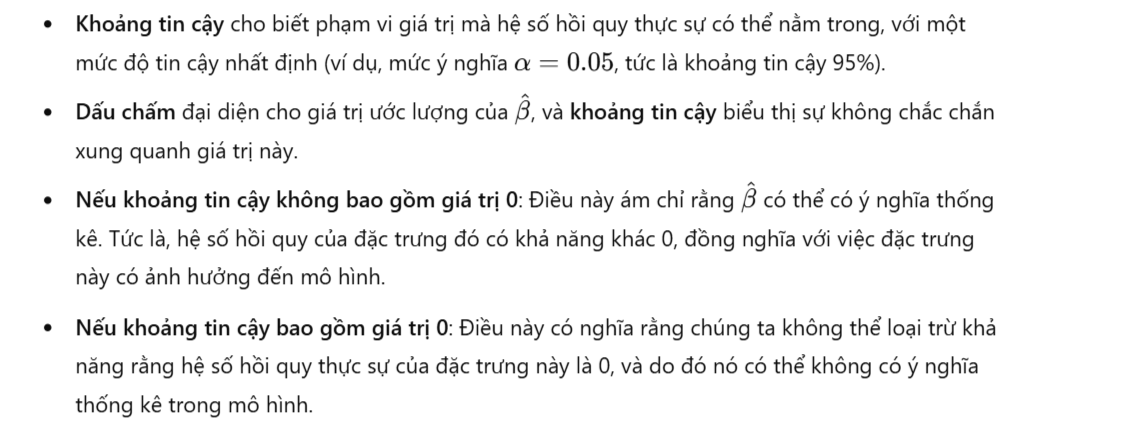

# **Generate Data**


In [23]:
import numpy as np

def generate_data(n, p, beta_vec):
    X = []
    y = []

    for i in range(n):
        X.append([])
        yi = 0
        for j in range(p):
            xij = np.random.normal(0,1)
            X[i].append(xij)
            yi = yi + xij * beta_vec[j]

        noise = np.random.normal(0, 1)
        yi = yi + noise
        y.append(yi)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [32]:
n = 100
p = 5
beta_vec = np.array([1,1,0,0,0])

features = [i+1 for i in range(p)]
lamda = 0.05

X, y = generate_data(n, p, beta_vec)

In [33]:
run_p_value(X, y, features, lamda)

Beta estimates from Lasso:
[[ 2.22975244]
 [ 2.02648817]
 [ 0.15504572]
 [-0.03969699]
 [-0.0612685 ]]
Error: denominator is zero
1: beta(LASSO): 2.22975243707651, test-statistic: 2.2424235099644076, p-value: None 
----------------------------------------------------
Error: denominator is zero
2: beta(LASSO): 2.026488169937126, test-statistic: 2.0456626271002833, p-value: None 
----------------------------------------------------
3: beta(LASSO): 0.1550457156975464, test-statistic: 0.16302754963147964, p-value: 0.23635788911571343 
----------------------------------------------------
4: beta(LASSO): -0.039696985926136207, test-statistic: -0.05098519936088821, p-value: 0.608204654051617 
----------------------------------------------------
5: beta(LASSO): -0.061268496321510754, test-statistic: -0.07360402587517607, p-value: 0.8901122179439096 
----------------------------------------------------


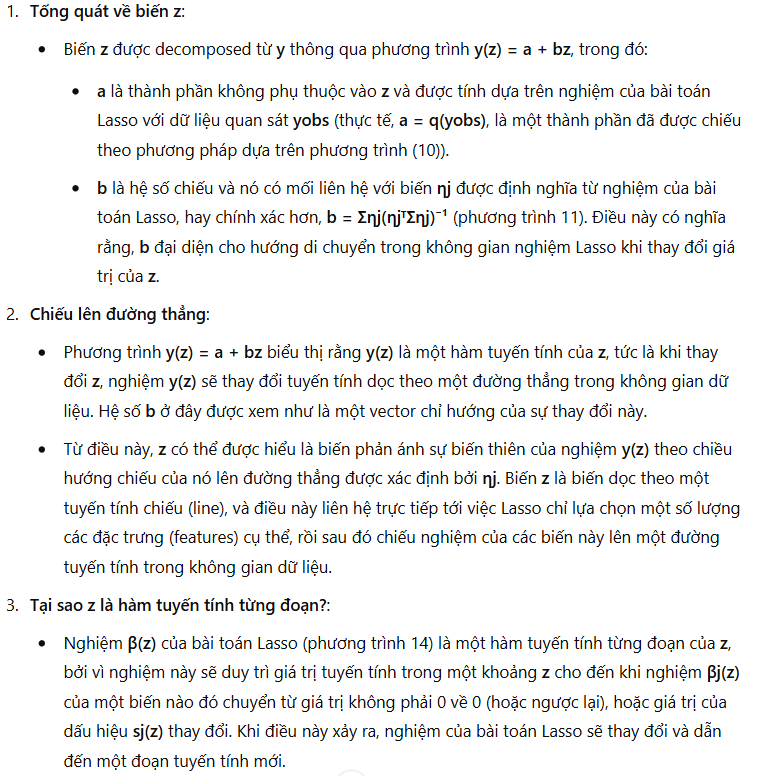

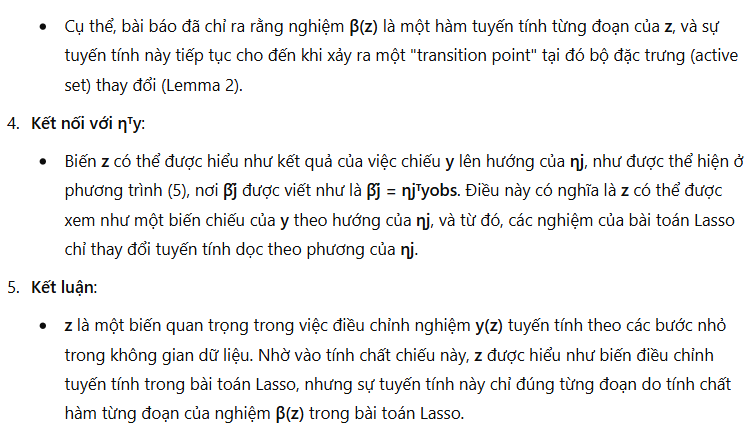